In [1]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import numpy as np
import matplotlib.pyplot as plt

# Creating the Test Set

To prevent look-ahead bias, we will assume that the co-integrated pairs for 2023 will continue to remain co-integrated throughout 2024. We will then extract the real prices and evaluate our trading strategy on these co-integrated pairs.

In [2]:
train_data = pd.read_csv("yearly_pairs_features.csv")
test_data = pd.read_csv("yearly_pairs_features_test.csv")

In [3]:
# Sort the test data chronologically
test_data['date'] = pd.to_datetime(test_data['date'])
test_data = test_data.sort_values(by=['pair', 'date']).reset_index(drop=True)

In [4]:
# Now our training set will consist of the validation dataset
print(train_data.shape)
print(test_data.shape)

(29332, 16)
(4267, 16)


In [5]:
# Define feature columns (exclude non-feature columns)
feature_cols = train_data.columns.difference(['date', 'pair', 'next_day_spread']).tolist()

# Initialize scalers
feature_scaler = StandardScaler()
target_scaler = StandardScaler()

# Scale features and target
X_train = feature_scaler.fit_transform(train_data[feature_cols])
y_train = target_scaler.fit_transform(train_data[['next_day_spread']]).flatten()

# Scale test features (test_data is assumed unscaled)
X_test_scaled = feature_scaler.transform(test_data[feature_cols])
y_test = test_data['next_day_spread'].values


# Fitting the best parameters of the XGBoost Model on the Train + Val Set 

In [6]:
#using the best params found in step 3_train_model.ipynb
xgboost_best_params = {'colsample_bytree': 1.0, 'gamma': 0, 'learning_rate': 0.05, 'max_depth': 3, 'n_estimators': 100, 'reg_alpha': 0, 'reg_lambda': 10, 'subsample': 0.6}

# Initialize the XGBoost model with the best parameters
xgb_model = XGBRegressor(
    random_state=42,
    tree_method='hist',
    device='cuda',
    **xgboost_best_params
)

# Fit the model on the training data
xgb_model.fit(X_train, y_train)

/Users/dylanlo/Desktop/qf206project/venv/lib/python3.12/site-packages/xgboost/training.py:183: UserWarning: [16:09:53] WARNING: /Users/runner/work/xgboost/xgboost/src/context.cc:203: XGBoost is not compiled with CUDA support.
  bst.update(dtrain, iteration=i, fobj=obj)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=1.0, device='cuda', early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=0, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=3,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=100,
             n_jobs=None, num_parallel_tree=None, ...)

In [ ]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

y_pred_scaled = xgb_model.predict(X_test_scaled)
y_test_scaled = target_scaler.transform(y_test.reshape(-1, 1)).flatten()

# Grab test matrics
print("MAE:", mean_absolute_error(y_test_scaled, y_pred_scaled))
print("MSE:", mean_squared_error(y_test_scaled, y_pred_scaled))
print("R²:", r2_score(y_test_scaled, y_pred_scaled))

MAE: 0.13997736576393197
MSE: 0.08400624939204594
R²: 0.9046811291445316


/Users/dylanlo/Desktop/qf206project/venv/lib/python3.12/site-packages/sklearn/utils/validation.py:2739: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


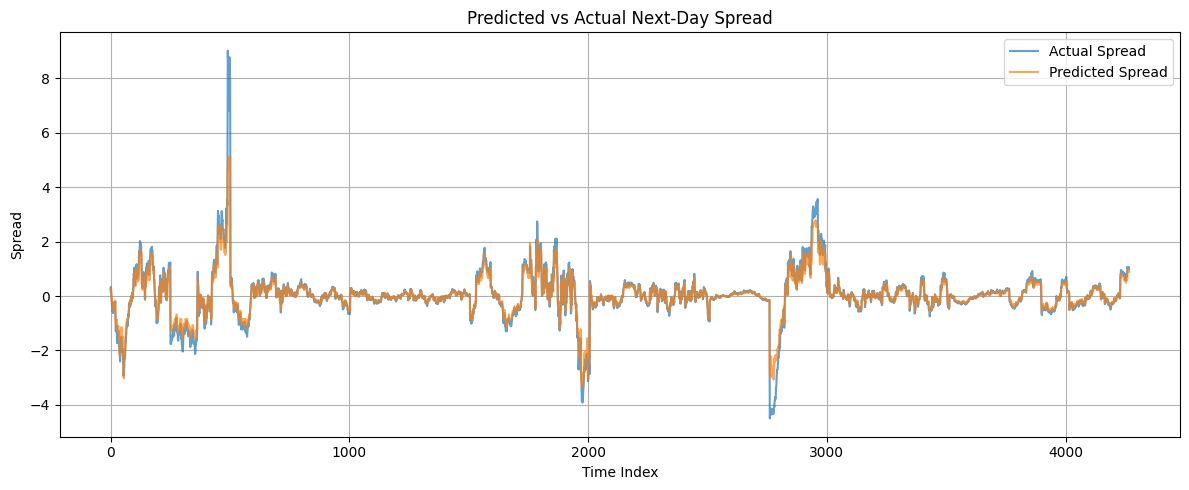

In [ ]:

# Plotting the grodund truth vs predicted values
plt.figure(figsize=(12, 5))
plt.plot(y_test_scaled, label='Actual Spread', alpha=0.7)
plt.plot(y_pred_scaled, label='Predicted Spread', alpha=0.7)
plt.title('Predicted vs Actual Next-Day Spread')
plt.xlabel('Time Index')
plt.ylabel('Spread')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


# Implementing Trading Strategy

In [ ]:
def calculate_forecasting_strategy_pnl(
    test_data, 
    feature_scaler, 
    target_scaler, 
    xgb_model,
    initial_capital=1000,
    transaction_cost=0.003
):
    # Predict next-day spread
    features = feature_scaler.transform(test_data[feature_cols])
    pred_spread_scaled = xgb_model.predict(features)
    pred_spread = target_scaler.inverse_transform(pred_spread_scaled.reshape(-1, 1)).flatten()

    # Get actual data for now
    price_A = test_data['price_A'].values
    price_B = test_data['price_B'].values
    actual_spread = test_data['spread'].values
    hedge_ratios = test_data['hedge_ratio'].values

    # Get change forecast - actual spread for determining trading signal
    delta_spread = pred_spread - actual_spread

    # Initialise positions aray
    positions_A = np.zeros(len(delta_spread))
    positions_B = np.zeros(len(delta_spread))

    # Generate positions based on delta spread 
    for t in range(1, len(delta_spread)):

        # Calculate the threshold for trading signal using the tran cost derived from trading both tickers
        threshold = transaction_cost * (price_A[t] + price_B[t])
        if delta_spread[t] > threshold:
            positions_A[t] = 1
            positions_B[t] = -1
        elif delta_spread[t] < -threshold:
            positions_A[t] = -1
            positions_B[t] = 1
        else: # Stay out of market (do nothing)
            positions_A[t] = 0
            positions_B[t] = 0

    # Calculate daily returns
    returns_A = np.concatenate([[0], np.diff(price_A) / price_A[:-1]])
    returns_B = np.concatenate([[0], np.diff(price_B) / price_B[:-1]])

    position_change = (
        (np.diff(positions_A, prepend=positions_A[0]) != 0) |
        (np.diff(positions_B, prepend=positions_B[0]) != 0)
    )

    portfolio_values = [initial_capital]
    strategy_daily_ret = np.zeros_like(returns_A)

    for t in range(1, len(returns_A)):
        ret = positions_A[t-1] * returns_A[t] + positions_B[t-1] * returns_B[t]
        cost = transaction_cost * (price_A[t] + hedge_ratios[t] * price_B[t]) if position_change[t] else 0
        daily_pnl = portfolio_values[-1] * ret - cost
        portfolio_values.append(portfolio_values[-1] + daily_pnl)
        strategy_daily_ret[t] = ret

    return np.array(portfolio_values), positions_A, positions_B, actual_spread


In [15]:
portfolio_results = {}
positions = {}
actual_spreads = {}

cumulative_returns_df = pd.DataFrame()

# For each co-int pair in the test data of Year 2024, run the forecasting strategy
for pair in test_data['pair'].unique():
    pair_data = test_data[test_data['pair'] == pair].copy()

    cumulative_returns, positions_A, positions_B, actual_spread = calculate_forecasting_strategy_pnl(pair_data, feature_scaler, target_scaler, xgb_model)

    # Save to dictionary for later analysis
    portfolio_results[pair] = cumulative_returns
    positions[pair] = (positions_A, positions_B)
    actual_spreads[pair] = actual_spread
    cumulative_returns_df[pair] = cumulative_returns

    print(f"Pair: {pair}, Final Portfolio Value: {cumulative_returns[-1]:.2f}")

cumulative_returns_df.to_csv("cumulative_returns.csv", index=False)

Pair: AVB-LOW, Final Portfolio Value: 1179.45
Pair: AVGO-KLAC, Final Portfolio Value: 747.96
Pair: AWK-HOLX, Final Portfolio Value: 1288.21
Pair: BAX-TECH, Final Portfolio Value: 884.94
Pair: BEN-FRT, Final Portfolio Value: 1162.82
Pair: CMS-RTX, Final Portfolio Value: 1069.52
Pair: DIS-T, Final Portfolio Value: 959.94
Pair: ENPH-WBD, Final Portfolio Value: 1534.55
Pair: ES-TSCO, Final Portfolio Value: 1818.71
Pair: EXPD-MLM, Final Portfolio Value: 973.25
Pair: FE-WEC, Final Portfolio Value: 1115.22
Pair: GE-TTWO, Final Portfolio Value: 2104.62
Pair: HSIC-UPS, Final Portfolio Value: 1157.16
Pair: IR-TDG, Final Portfolio Value: 1000.00
Pair: KIM-NSC, Final Portfolio Value: 1000.00
Pair: SCHW-USB, Final Portfolio Value: 1285.30
Pair: SRE-VICI, Final Portfolio Value: 1085.36


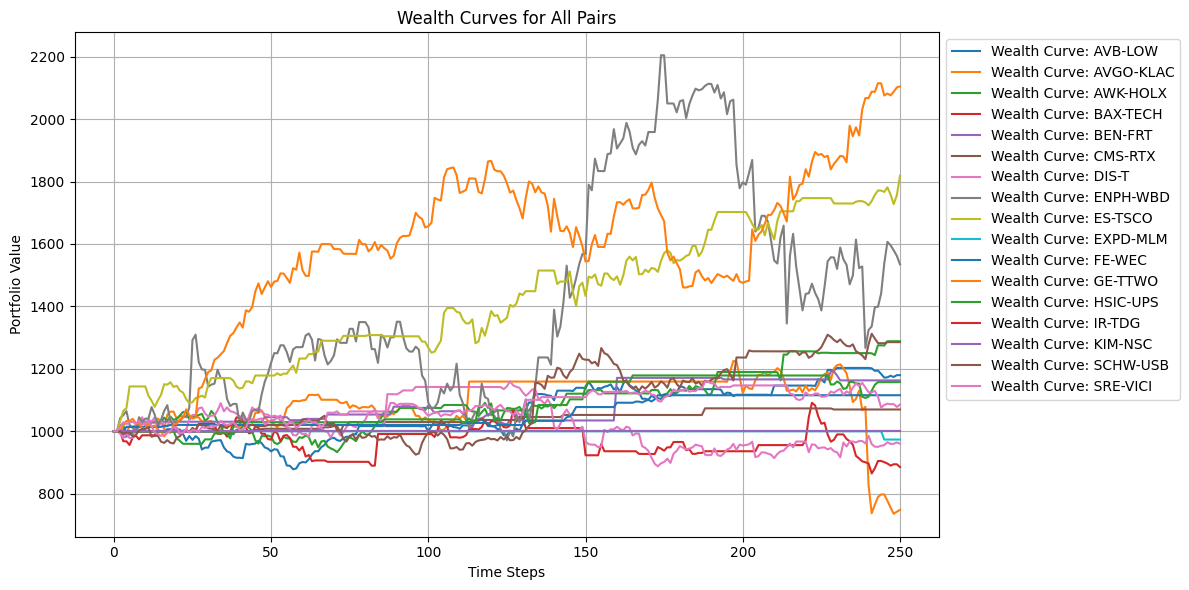

In [ ]:
# Plot wealth curves for all pairs in one graph, sshow results of all pair
plt.figure(figsize=(12, 6))

for pair, cumulative_returns in portfolio_results.items():
    plt.plot(cumulative_returns, label=f"Wealth Curve: {pair}")

plt.title("Wealth Curves for All Pairs")
plt.xlabel("Time Steps")
plt.ylabel("Portfolio Value")
plt.legend(loc="upper left", bbox_to_anchor=(1, 1))
plt.grid(True)
plt.tight_layout() 
plt.show()

In [ ]:
def plot_strategy_outputs(pair_name, test_data, actual_spread, portfolio_values, positions_A, positions_B):
    if isinstance(test_data.index, pd.DatetimeIndex):
        dates = test_data.index
        use_pandas_index = True
    else:
        dates = np.arange(len(test_data))
        use_pandas_index = False

    spread_position = positions_A  # 1 = long spread, -1 = short spread, 0 = flat, vice versa for positions_B
    spread_position_series = pd.Series(spread_position, index=dates)

    # Find entry points (long/short) denoted by 1 and -1
    position_change = spread_position_series.diff().fillna(0)
    long_entry_idx = position_change[position_change > 0.5].index
    short_entry_idx = position_change[position_change < -0.5].index

    # Find exit points (from any non-zero position to flat)
    exit_idx = position_change[(spread_position_series.shift(1) != 0) & (spread_position_series == 0)].index

    fig, ax1 = plt.subplots(figsize=(14, 6))

    # Plot portfolio value
    ax1.plot(dates, portfolio_values, label='Portfolio Value', color='green')
    ax1.set_ylabel('Portfolio Value', color='green')
    ax1.tick_params(axis='y', labelcolor='green')

    # plot entry makers
    if use_pandas_index:
        ax1.plot(long_entry_idx, portfolio_values[[dates.get_loc(d) for d in long_entry_idx]],
                 '^', color='blue', markersize=10, label='Long Spread Entry')
        ax1.plot(short_entry_idx, portfolio_values[[dates.get_loc(d) for d in short_entry_idx]],
                 'v', color='red', markersize=10, label='Short Spread Entry')
        ax1.plot(exit_idx, portfolio_values[[dates.get_loc(d) for d in exit_idx]],
                 'o', color='purple', markersize=8, label='Exit')
    else:
        long_indices = np.searchsorted(dates, long_entry_idx)
        short_indices = np.searchsorted(dates, short_entry_idx)
        exit_indices = np.searchsorted(dates, exit_idx)

        ax1.plot(dates[long_indices], portfolio_values[long_indices],
                 '^', color='blue', markersize=10, label='Long Spread Entry')
        ax1.plot(dates[short_indices], portfolio_values[short_indices],
                 'v', color='red', markersize=10, label='Short Spread Entry')
        ax1.plot(dates[exit_indices], portfolio_values[exit_indices],
                 'o', color='purple', markersize=8, label='Exit')

    # Twin axis for delta spread
    ax2 = ax1.twinx()
    ax2.plot(dates, actual_spread, label='Actual Spread', color='black', alpha=0.6)
    ax2.axhline(0, linestyle='--', color='gray', linewidth=1)
    ax2.set_ylabel('Actual Spread', color='black')
    ax2.tick_params(axis='y', labelcolor='black')

    # Combine legends
    lines_1, labels_1 = ax1.get_legend_handles_labels()
    lines_2, labels_2 = ax2.get_legend_handles_labels()
    ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

    plt.title(f'PAIR: {pair_name}, Portfolio Value, Actual Spread, and Trade Entry/Exit Points' )
    plt.xlabel('Time')
    plt.tight_layout()
    plt.show()


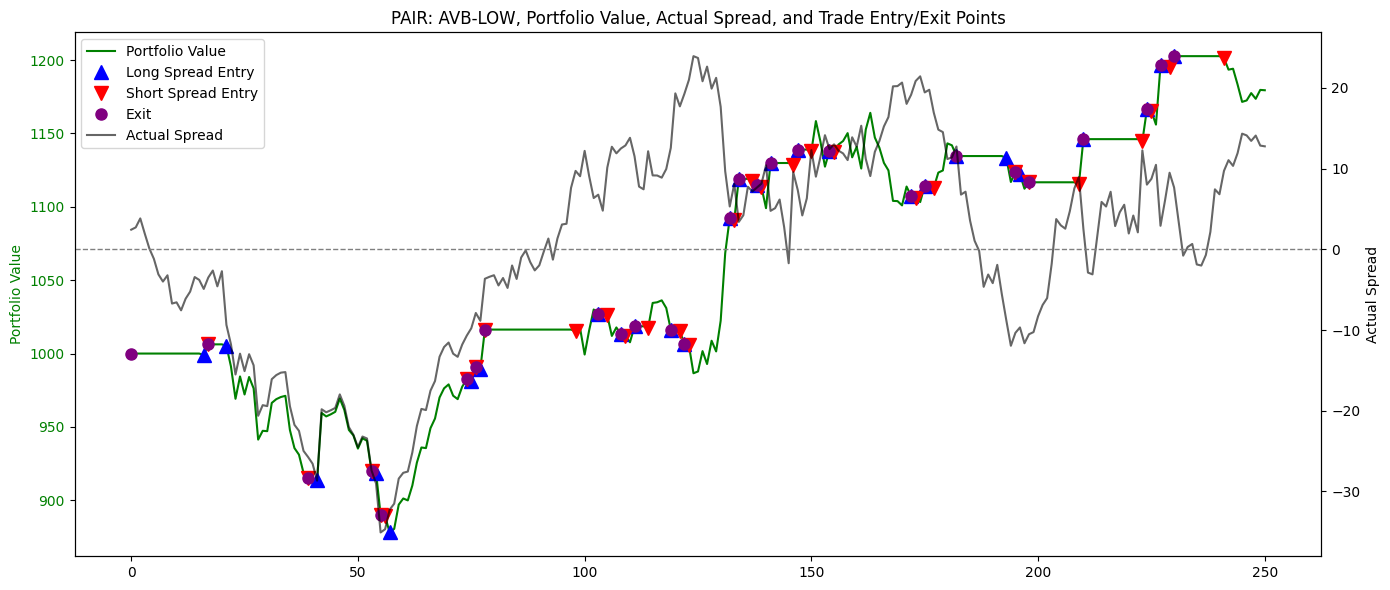

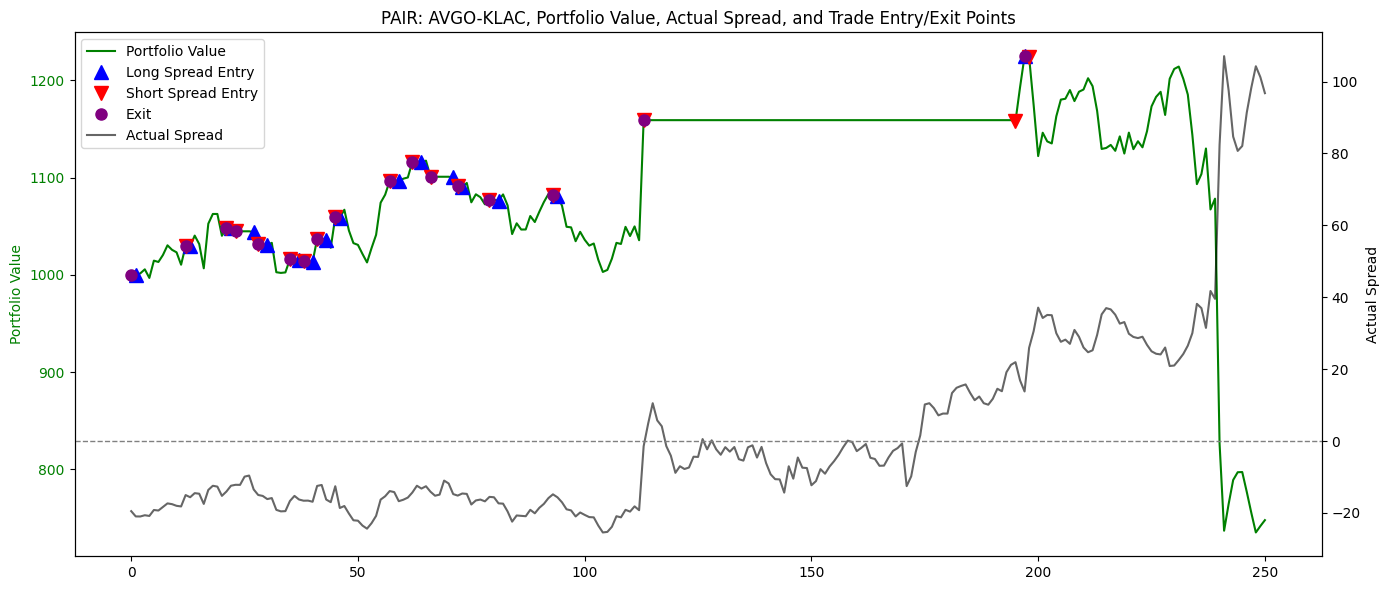

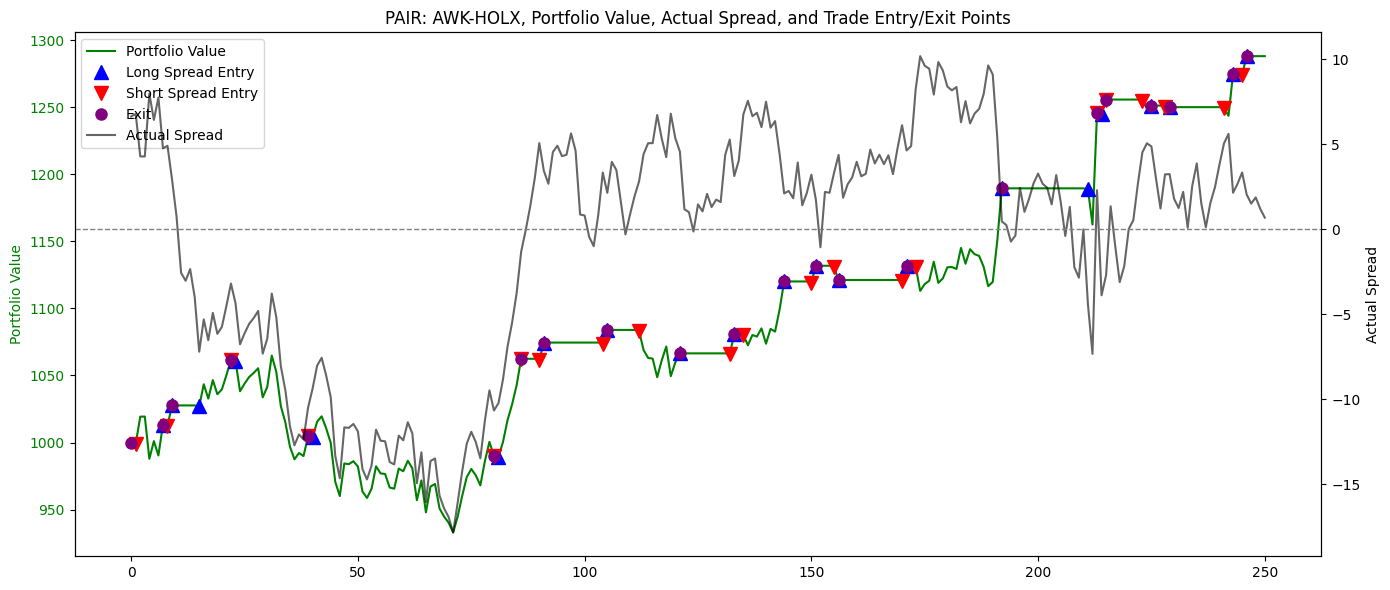

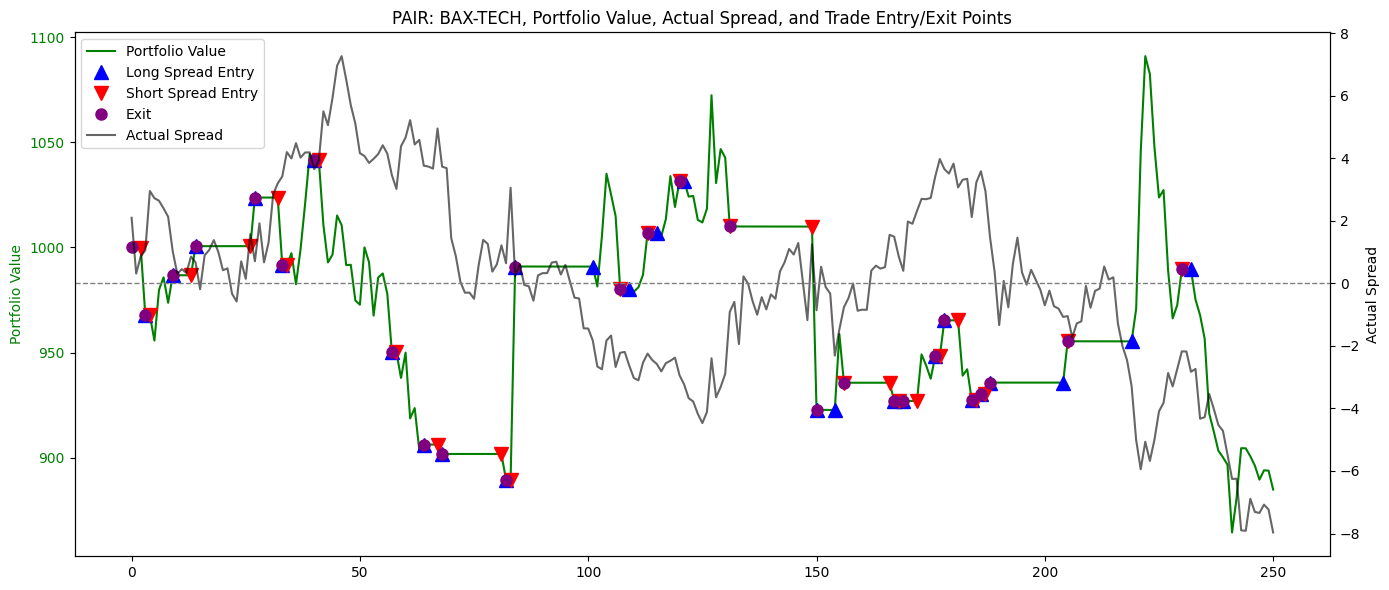

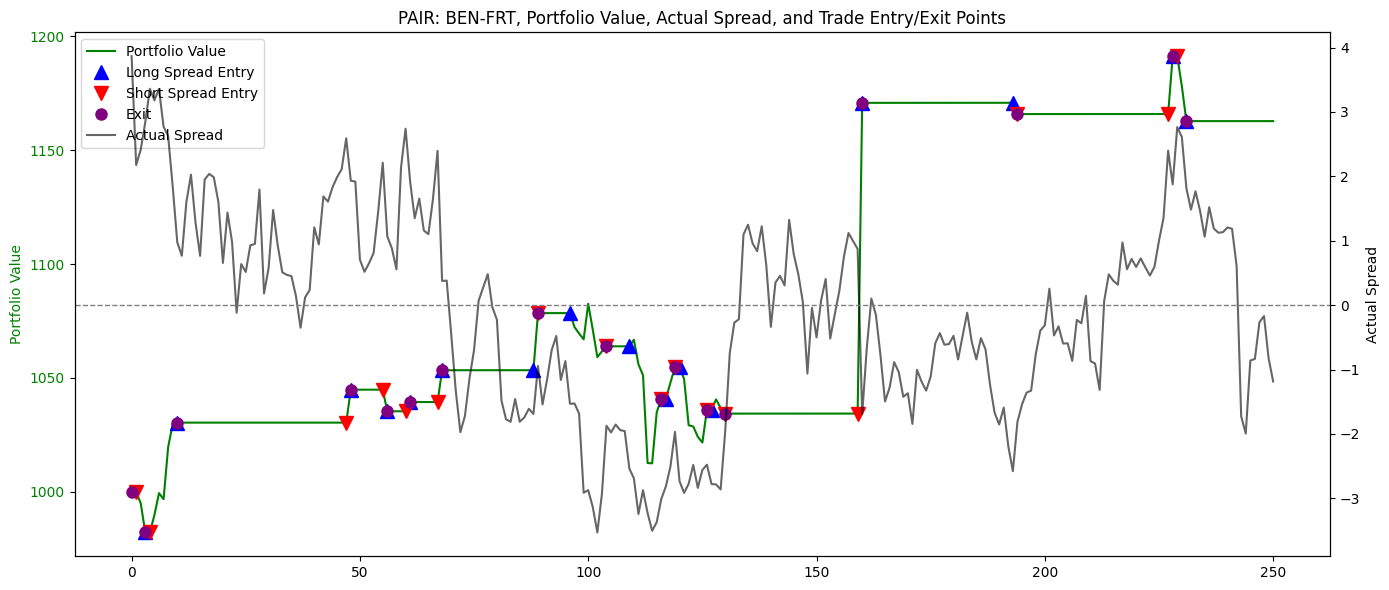

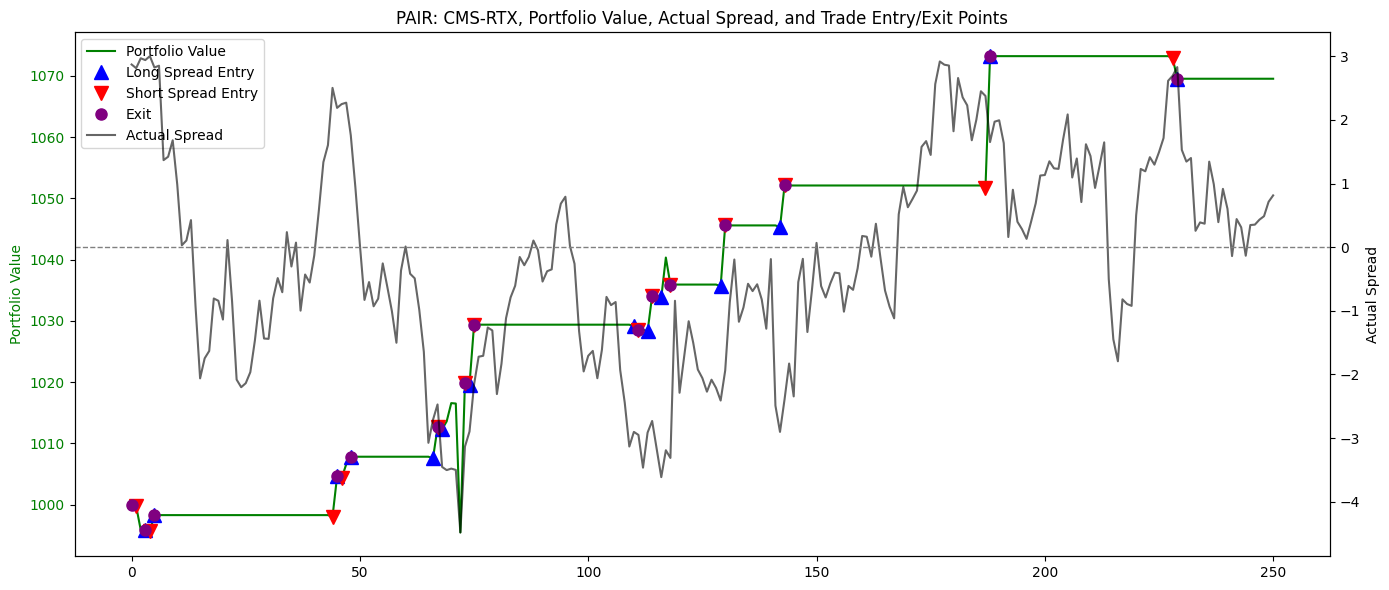

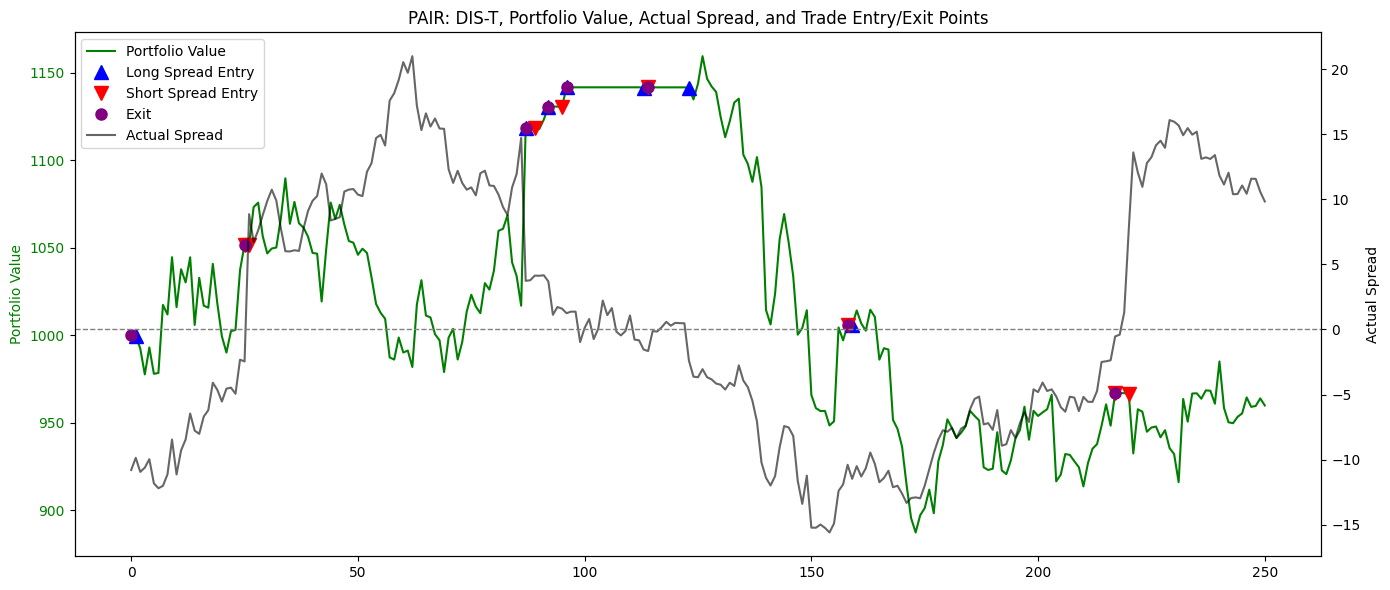

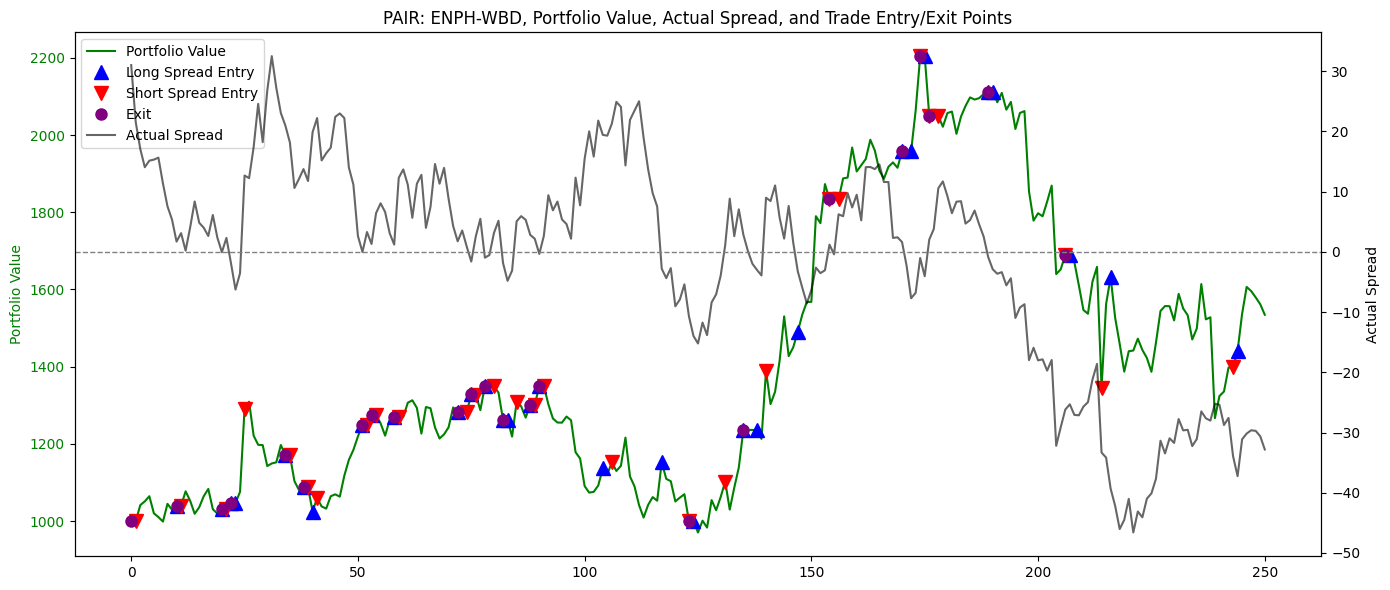

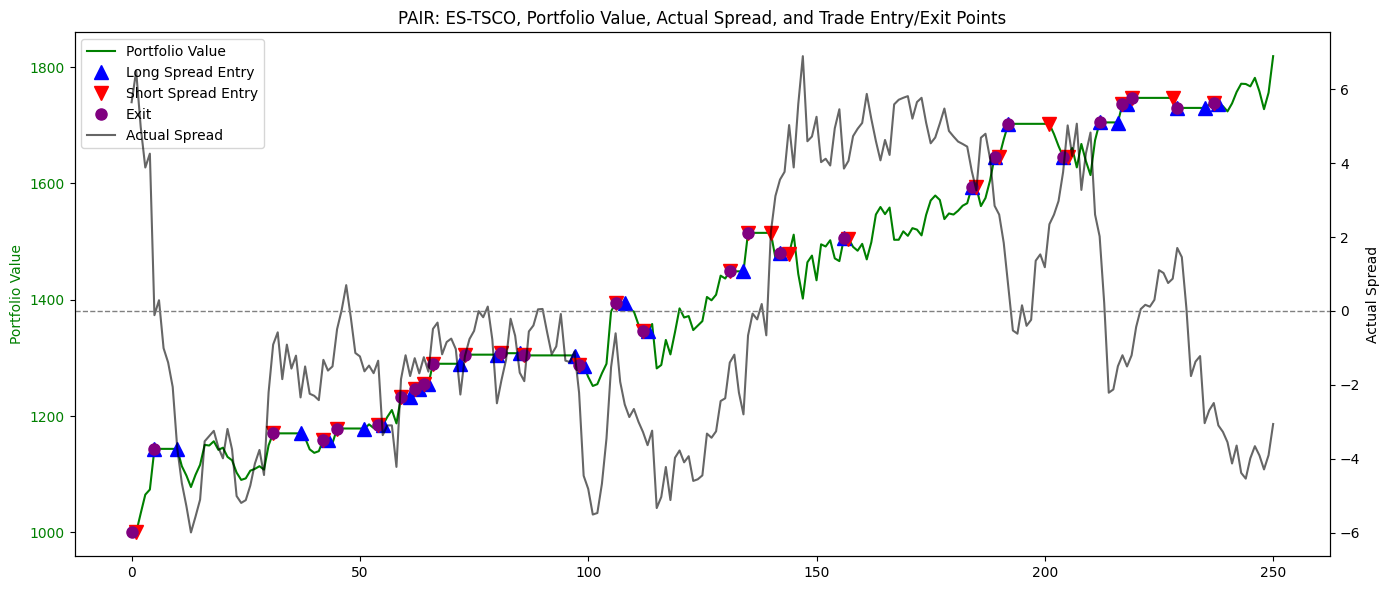

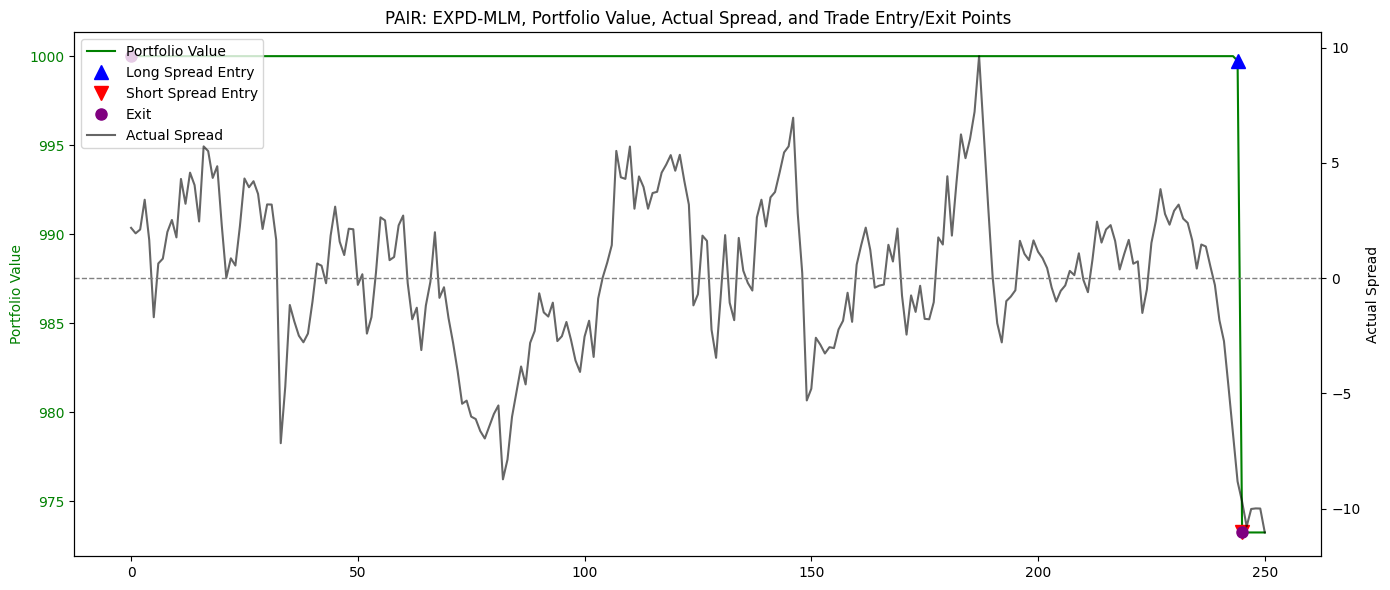

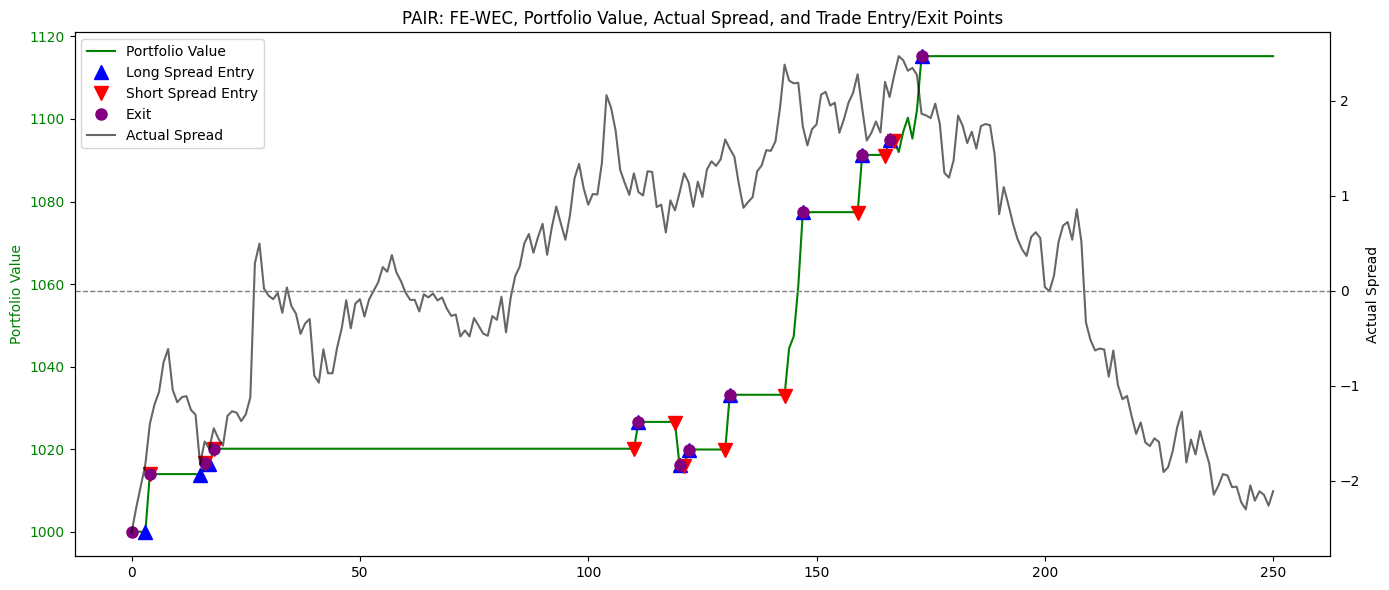

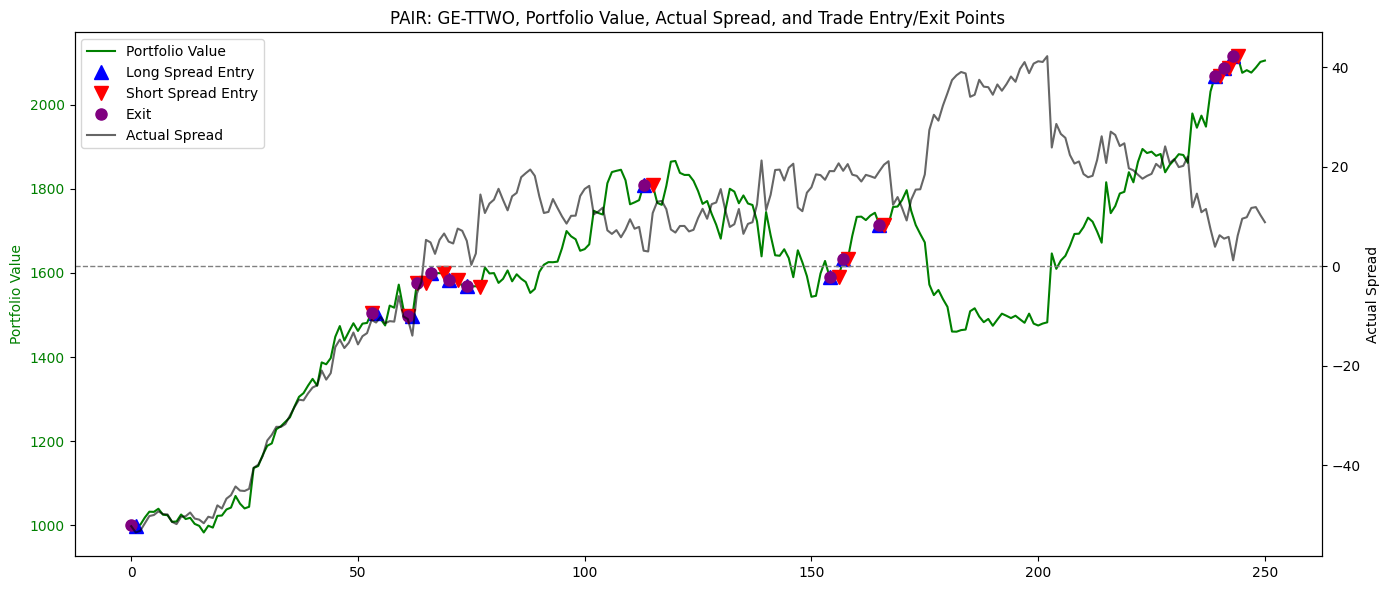

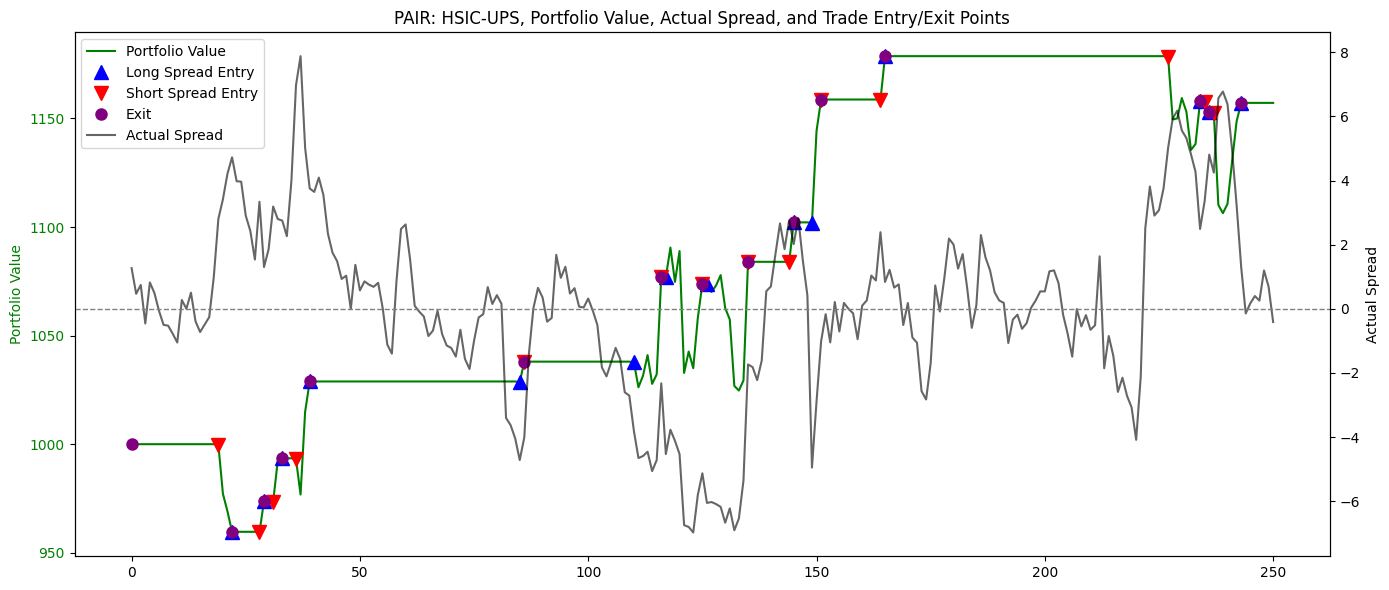

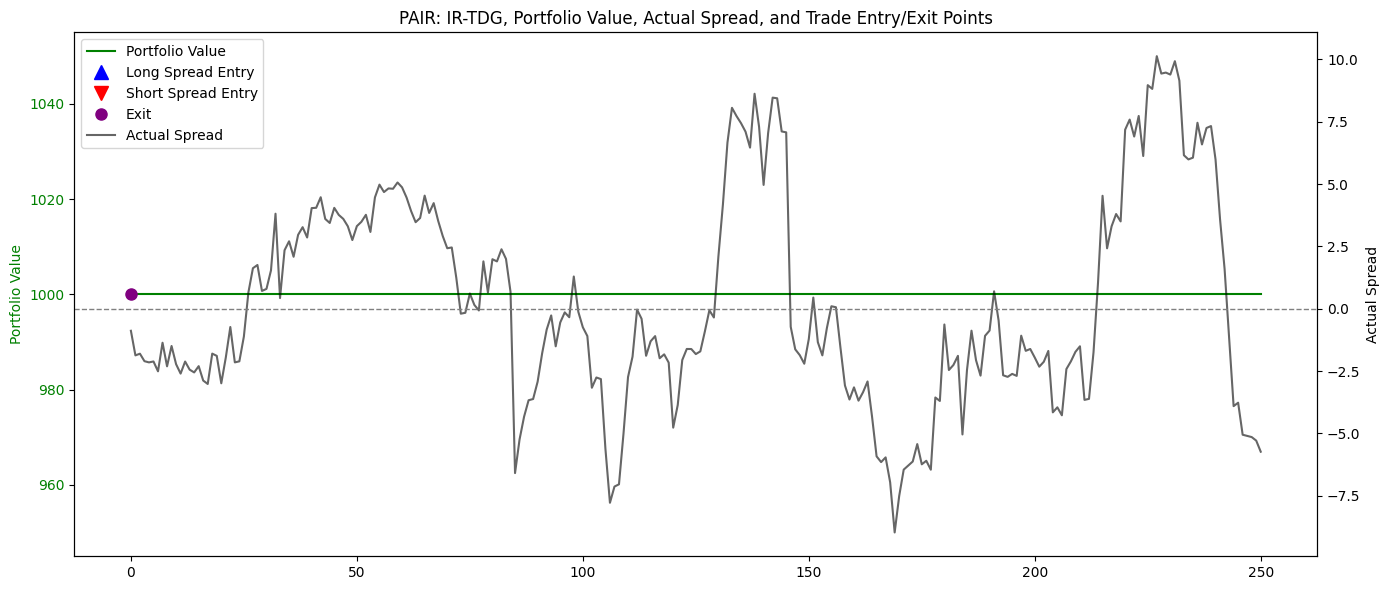

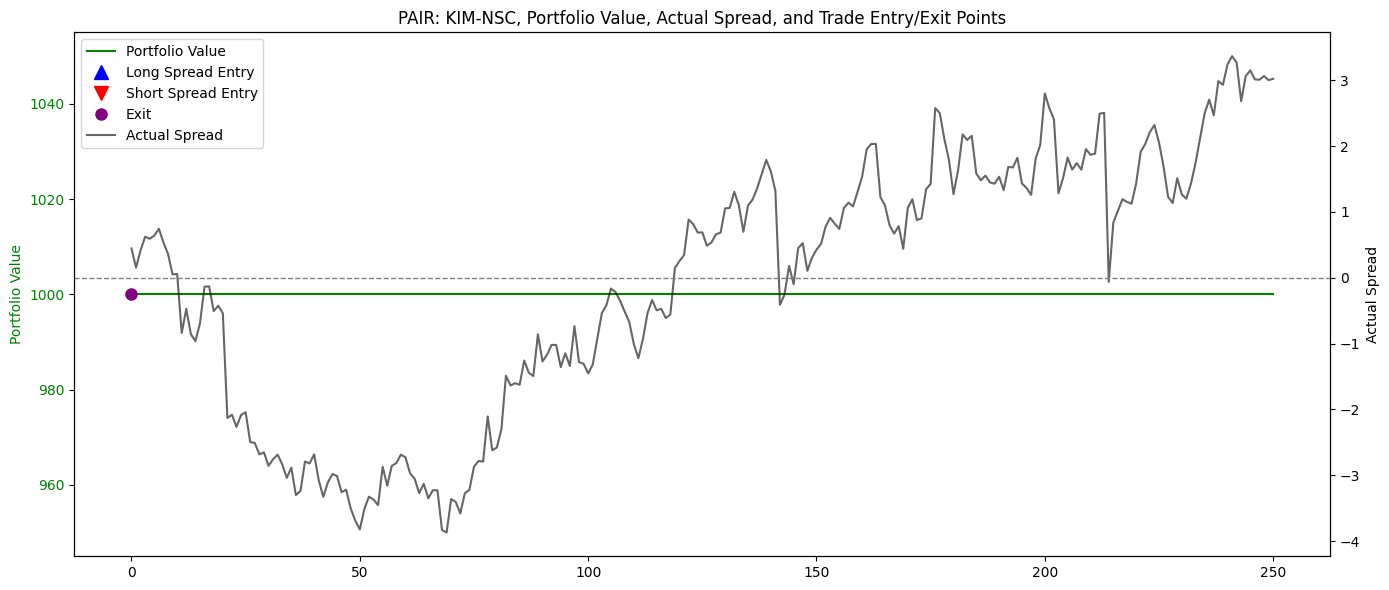

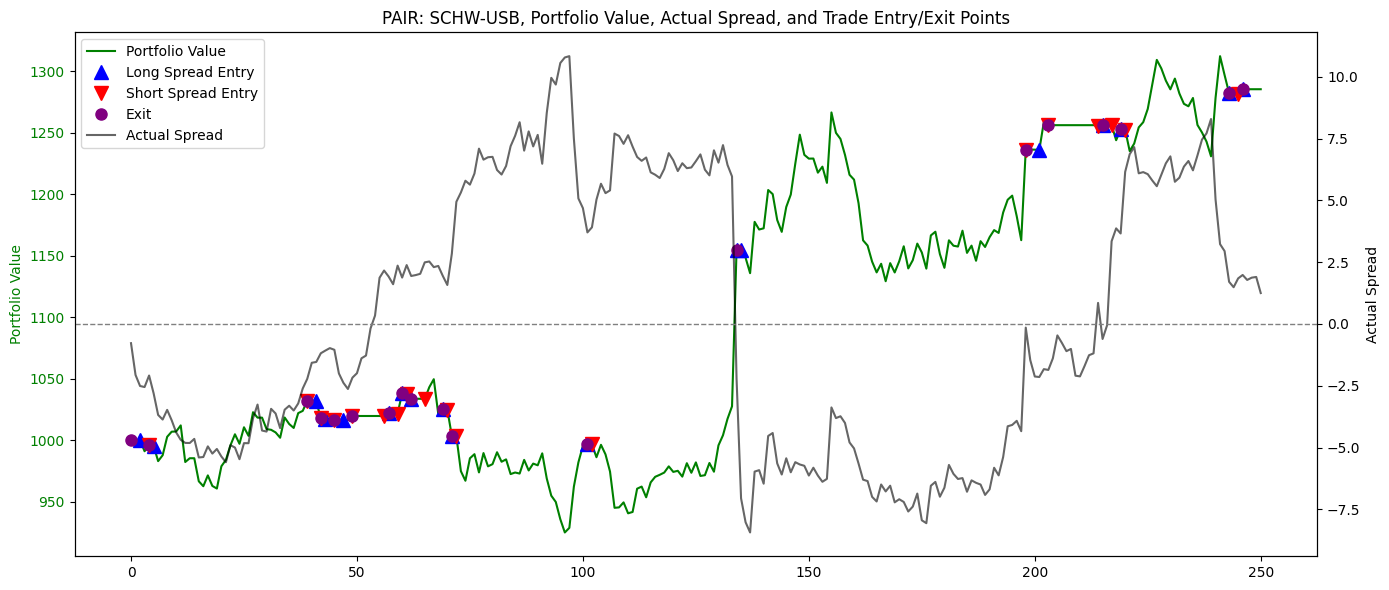

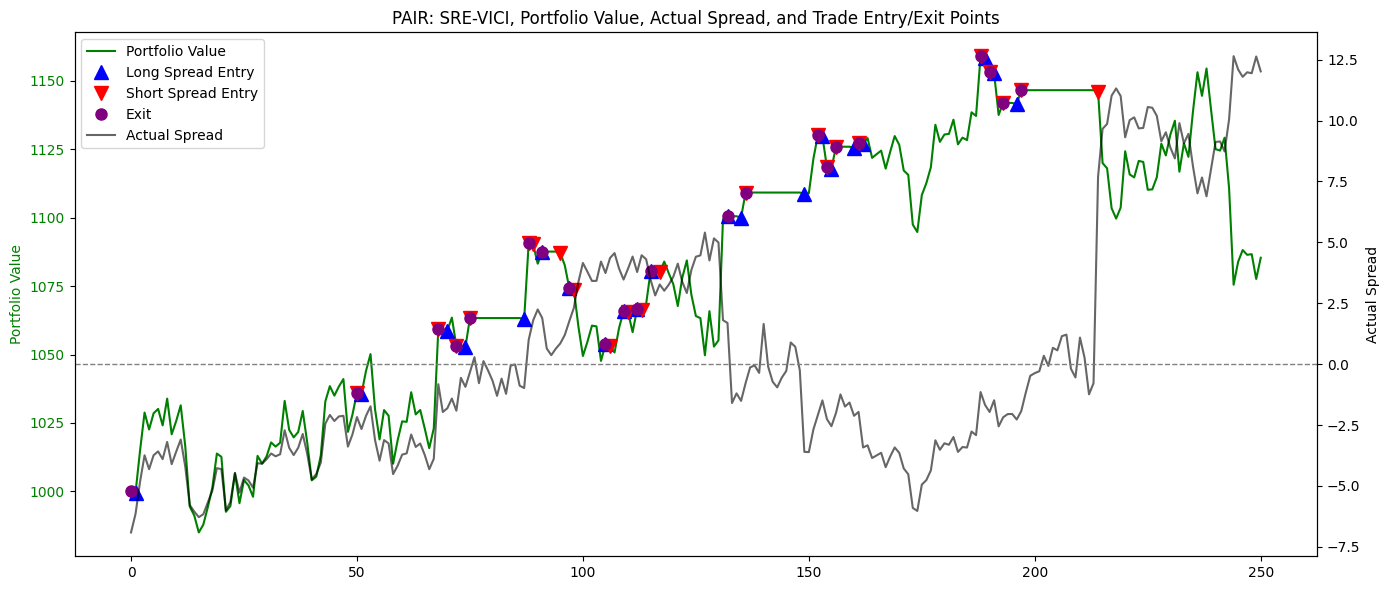

In [13]:
for pair in test_data['pair'].unique():
    plot_strategy_outputs(pair, test_data[test_data['pair'] == pair], actual_spreads[pair], portfolio_results[pair], positions[pair][0], positions[pair][1])

In [14]:
# Compute total PnL
initial_capital = 1000
total_pnl = sum(returns[-1] - initial_capital for returns in portfolio_results.values())
print(f"Percentage Return (Excluding Anomaly): {(total_pnl / (initial_capital * len(portfolio_results))) * 100:.2f}%")

# Compute daily returns for all pairs
all_daily_returns = []
for returns in portfolio_results.values():
    daily_returns = np.diff(returns)  # Calculate daily returns from cumulative returns
    all_daily_returns.extend(daily_returns)

# Convert to numpy array
all_daily_returns = np.array(all_daily_returns)

# Compute Sharpe Ratio
risk_free_rate = 0.03  
mean_return = np.mean(all_daily_returns)
std_dev_return = np.std(all_daily_returns)
sharpe_ratio = (mean_return - risk_free_rate) / std_dev_return if std_dev_return != 0 else 0

print(f"Sharpe Ratio of Portfolio (Excluding Anomaly): {sharpe_ratio:.2f}")

Percentage Return (Excluding Anomaly): 19.81%
Sharpe Ratio of Portfolio (Excluding Anomaly): 0.04
